In [1]:
# DataFrame library
import pandas as pd

# Plotting library
import matplotlib.pyplot as plt

# Statistics plotting library based on matplotlib
import seaborn as sns

# Array library
import numpy as np

# Regular expression library for text parsing and extraction
import re

In [2]:
# Loads the 2023 data
chess_games_2023 = pd.read_csv("./data/chess_games_2023.csv")

# Loads the 2024 data
chess_games_2024 = pd.read_csv("./data/chess_games_2024.csv")

# Combines both years of data
chess_games = pd.concat([chess_games_2023, chess_games_2024], ignore_index = True)

In [3]:
# Gives us an overview of the combined dataframe
chess_games.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1328 entries, 0 to 1327
Data columns (total 26 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Unnamed: 0        1328 non-null   int64  
 1   url               1328 non-null   object 
 2   pgn               1328 non-null   object 
 3   time_control      1328 non-null   object 
 4   end_time          1328 non-null   int64  
 5   rated             1328 non-null   bool   
 6   tcn               1328 non-null   object 
 7   uuid              1328 non-null   object 
 8   initial_setup     1328 non-null   object 
 9   fen               1328 non-null   object 
 10  time_class        1328 non-null   object 
 11  rules             1328 non-null   object 
 12  white.rating      1328 non-null   int64  
 13  white.result      1328 non-null   object 
 14  white.@id         1328 non-null   object 
 15  white.username    1328 non-null   object 
 16  white.uuid        1328 non-null   object 


In [4]:
# The number of rows and columns for the 2023 games
chess_games_2023.shape

(495, 25)

In [5]:
# The number of rows and columns for the 2024 games
chess_games_2024.shape

(833, 26)

In [6]:
# Tests to make sure that the 2023 and 2024 dataframes add up (if successful there shouldn't be an output)
assert chess_games_2023.shape[0] + chess_games_2024.shape[0] == chess_games.shape[0]

In [7]:
# The columns currently in the dataframe
chess_games.columns

Index(['Unnamed: 0', 'url', 'pgn', 'time_control', 'end_time', 'rated', 'tcn',
       'uuid', 'initial_setup', 'fen', 'time_class', 'rules', 'white.rating',
       'white.result', 'white.@id', 'white.username', 'white.uuid',
       'black.rating', 'black.result', 'black.@id', 'black.username',
       'black.uuid', 'start_time', 'accuracies.white', 'accuracies.black',
       'tournament'],
      dtype='object')

In [8]:
columns_to_drop = ["Unnamed: 0", "rated", "tcn", "uuid", "initial_setup", "accuracies.white", "accuracies.black", 
                   "fen", "rules", "white.@id", "white.uuid", "black.@id", "black.uuid"]
chess_games.drop(columns = columns_to_drop, inplace = True)

In [9]:
# Types of games that were played
chess_games["time_class"].unique()

array(['blitz', 'bullet', 'daily', 'rapid'], dtype=object)

In [10]:
# Unique results for white and black (it will be the same results regardless of what column gets picked)
print(np.sort(chess_games["white.result"].unique()))

['abandoned' 'agreed' 'checkmated' 'insufficient' 'repetition' 'resigned'
 'stalemate' 'timeout' 'timevsinsufficient' 'win']


In [11]:
def game_result(df):
    """Determines whether a game was won, lost, or drawn and puts it in a list. 
    The intention is to create another column that can list the result per game regardless of what color was played.

    Args:
        df (pandas.DataFrame): the data that contains all the chess games

    Returns:
        list : Returns a list of outcomes that are one of the three states (Won, Lost, or Draw)
    """
    results = []
    for white_result, white_username, black_result, black_username in zip(df["white.result"], df["white.username"], df["black.result"], df["black.username"]):
        if (white_result == "win" and white_username == "hfactor13") or (black_result == "win" and black_username == "hfactor13"):
            results.append("Won")
        elif white_result == black_result:
            results.append("Draw")
        else:
            results.append("Lost")
    return results

In [12]:
chess_games["game_result"] = game_result(chess_games) 

In [13]:
def my_rating(df):
    """This aggregates rating for all time regardless of the colored piece played.

    Args:
        df (pandas.DataFrame): the data that contains all the chess games

    Returns:
        list: Returns a list of ratings
    """
    rating = []
    for white_rating, black_rating, white_username, black_username in zip(df["white.rating"], df["black.rating"], df["white.username"], df["black.username"]):
        if white_username == "hfactor13":
            rating.append(white_rating)
        elif black_username == "hfactor13":
            rating.append(black_rating)
    return rating

In [14]:
chess_games["my_rating"] = my_rating(chess_games)

In [15]:
# Writes out PGN data to a file (this will be helpful to extract missing information that wasn't already available in the API)
pgn_data = chess_games["pgn"]
with open("./data/pgn_data.pgn", "w") as p:
    p.writelines(pgn_data + "\n")

In [16]:
# Reads in the data from the newly created PGN file to extract information (i.e. the start and end times and the dates)
with open("./data/pgn_data.pgn", "r") as p:
    pgn_text = p.readlines()
pgn_text[:24]

['[Event "Live Chess"]\n',
 '[Site "Chess.com"]\n',
 '[Date "2023.01.18"]\n',
 '[Round "-"]\n',
 '[White "hfactor13"]\n',
 '[Black "MrEvi10verlord"]\n',
 '[Result "0-1"]\n',
 '[CurrentPosition "r6k/ppp4p/2n1r3/8/1nPp4/1P3p2/P1q5/RK4R1 w - -"]\n',
 '[Timezone "UTC"]\n',
 '[ECO "A01"]\n',
 '[ECOUrl "https://www.chess.com/openings/Nimzowitsch-Larsen-Attack-Modern-Variation"]\n',
 '[UTCDate "2023.01.18"]\n',
 '[UTCTime "02:03:52"]\n',
 '[WhiteElo "660"]\n',
 '[BlackElo "795"]\n',
 '[TimeControl "180"]\n',
 '[Termination "MrEvi10verlord won by checkmate"]\n',
 '[StartTime "02:03:52"]\n',
 '[EndDate "2023.01.18"]\n',
 '[EndTime "02:08:39"]\n',
 '[Link "https://www.chess.com/game/live/67746611751"]\n',
 '\n',
 '1. b3 {[%clk 0:02:55.3]} 1... e5 {[%clk 0:02:59.8]} 2. Nf3 {[%clk 0:02:50.5]} 2... Nc6 {[%clk 0:02:58]} 3. g3 {[%clk 0:02:48.6]} 3... d5 {[%clk 0:02:57.8]} 4. c4 {[%clk 0:02:42.1]} 4... Bc5 {[%clk 0:02:54.4]} 5. Bb2 {[%clk 0:02:35.1]} 5... f6 {[%clk 0:02:46.2]} 6. h4 {[%clk 0:02:27.3]}

In [17]:
# Parses text for dates, times, openings, moves, and link to the game
start_times_info = []
end_times_info = []
start_dates_info = []
end_dates_info = []
openings = []
moves = []

for text in pgn_text:
    if re.match("\[StartTime", text):
        start_times_info.append(text)
    elif re.match("\[EndTime", text):
        end_times_info.append(text)
    elif re.match("\[Date", text):
        start_dates_info.append(text)
    elif re.match("\[EndDate", text):
        end_dates_info.append(text)
    elif re.match("\[ECOUrl", text):
        openings.append(text)
    elif re.match("1\.", text):
        moves.append(text)

In [18]:
# Strips out the unneccessary characters at the end (", ], \n)
openings = [o[40:].strip().strip("]").strip("\"") for o in openings]
openings[:10]

['Nimzowitsch-Larsen-Attack-Modern-Variation',
 'Modern-Defense-with-1-e4-2.d4-Bg7-3.Be3',
 'Nimzowitsch-Larsen-Attack-Dutch-Variation',
 'Reti-Opening-Kingside-Fianchetto-Variation',
 'Nimzowitsch-Larsen-Attack-Classical-Variation-2.Bb2',
 'English-Opening-Kings-English-Variation-2.b3-Nc6-3.Bb2',
 'Petrovs-Defense-3.d3-Nc6-4.Be2',
 'Queens-Gambit',
 'Indian-Game-2.e3',
 'Caro-Kann-Defense-Two-Knights-Attack']

In [19]:
# Looking at the last 50 characters to determine the total number of moves in the game
last_moves = [m[-50:] for m in moves]
last_moves[:10]

['clk 0:00:07.4]} 29... Qc2# {[%clk 0:01:20.2]} 0-1\n',
 ' {[%clk 0:00:21.2]} 21. g3 {[%clk 0:00:45.3]} 1-0\n',
 '[%clk 0:00:01.1]} 25... h6 {[%clk 0:00:09.9]} 0-1\n',
 '[%clk 0:00:55.3]} 32. Rxh4 {[%clk 0:02:39.7]} 1-0\n',
 '%clk 0:00:01.4]} 26... Qb7 {[%clk 0:00:04.6]} 0-1\n',
 '[%clk 23:57:51]} 17... Qxb4 {[%clk 23:59:42]} 0-1\n',
 '3 {[%clk 0:02:17]} 37. Rf4 {[%clk 0:03:18.1]} 1-0\n',
 '[%clk 0:04:05.6]} 39. Qe6# {[%clk 0:04:14.9]} 1-0\n',
 '%clk 0:00:00.4]} 40... Rg6 {[%clk 0:04:13.8]} 0-1\n',
 '[%clk 0:00:05.3]} 21. Nxd4 {[%clk 0:00:13.9]} 1-0\n']

In [20]:
# Reduces the string length so that it starts with '}' and end with '.'
total_moves = [re.findall("\} \d+\.", l)[0] for l in last_moves]

# Extracts the digits which signify the total number of moves
total_moves = [int(re.findall("\d+", total)[0]) for total in total_moves]
total_moves[:10]

[29, 21, 25, 32, 26, 17, 37, 39, 40, 21]

In [21]:
# Add the newly extracted information to the combined games dataframe
chess_games["start_time"] = pd.to_timedelta([re.findall("\d+:\d+:\d+", s)[0] for s in start_times_info])
chess_games["end_time"] = pd.to_timedelta([re.findall("\d+:\d+:\d+", s)[0] for s in end_times_info])
chess_games["start_date"] = pd.to_datetime([re.findall("\d+\.\d+\.\d+", s)[0] for s in start_dates_info])
chess_games["end_date"] = pd.to_datetime([re.findall("\d+\.\d+\.\d+", s)[0] for s in end_dates_info])
chess_games["openings"] = openings
chess_games["total_moves"] = total_moves

In [22]:
# Condense date and time columns to one column (the relevant datetime information can be accessed from the datetime attribute in pandas)
chess_games["start_date"] = chess_games["start_date"] + chess_games["start_time"]
chess_games["end_date"] = chess_games["end_date"] + chess_games["end_time"]

# Drops the redundant time columns
chess_games.drop(columns = ["start_time", "end_time"], inplace = True)

In [23]:
# Double checking format of start and end date columns
chess_games[["start_date", "end_date"]]

,start_date,end_date
0,2023-01-18 02:03:52,2023-01-18 02:08:39
1,2023-01-18 02:09:23,2023-01-18 02:14:48
2,2023-01-19 00:55:37,2023-01-19 00:57:40
3,2023-01-19 00:58:08,2023-01-19 01:05:01
4,2023-01-19 01:05:17,2023-01-19 01:15:26
...,...,...
1323,2024-09-03 04:44:48,2024-09-03 04:48:09
1324,2024-09-03 19:22:53,2024-09-03 19:26:53
1325,2024-09-03 19:27:04,2024-09-03 19:32:23
1326,2024-09-03 23:41:42,2024-09-03 23:47:14


In [24]:
# Filters out games where there were possibly interruptions or just disconnected entirely
filtered_idx = (chess_games["total_moves"] > 5) & (chess_games["white.result"] != "abandoned") & (chess_games["black.result"] != "abandoned")
chess_games = chess_games[filtered_idx]
chess_games

,url,pgn,time_control,time_class,white.rating,white.result,white.username,black.rating,black.result,black.username,tournament,game_result,my_rating,start_date,end_date,openings,total_moves
0,https://www.chess.com/game/live/67746611751,"[Event ""Live Chess""]\n[Site ""Chess.com""]\n[Dat...",180,blitz,660,checkmated,hfactor13,795,win,MrEvi10verlord,NaN,Lost,660,2023-01-18 02:03:52,2023-01-18 02:08:39,Nimzowitsch-Larsen-Attack-Modern-Variation,29
1,https://www.chess.com/game/live/67746710345,"[Event ""Live Chess""]\n[Site ""Chess.com""]\n[Dat...",180,blitz,618,win,YasssQueen9,520,timeout,hfactor13,NaN,Lost,520,2023-01-18 02:09:23,2023-01-18 02:14:48,Modern-Defense-with-1-e4-2.d4-Bg7-3.Be3,21
2,https://www.chess.com/game/live/67828846779,"[Event ""Live Chess""]\n[Site ""Chess.com""]\n[Dat...",60,bullet,398,timeout,hfactor13,572,win,rico24432,NaN,Lost,398,2023-01-19 00:55:37,2023-01-19 00:57:40,Nimzowitsch-Larsen-Attack-Dutch-Variation,25
3,https://www.chess.com/game/live/67828893903,"[Event ""Live Chess""]\n[Site ""Chess.com""]\n[Dat...",300,blitz,555,win,YusufAwaisu,437,resigned,hfactor13,NaN,Lost,437,2023-01-19 00:58:08,2023-01-19 01:05:01,Reti-Opening-Kingside-Fianchetto-Variation,32
4,https://www.chess.com/game/live/67829440503,"[Event ""Live Chess""]\n[Site ""Chess.com""]\n[Dat...",300,blitz,348,timeout,hfactor13,367,win,DamianCapponi,NaN,Lost,348,2023-01-19 01:05:17,2023-01-19 01:15:26,Nimzowitsch-Larsen-Attack-Classical-Variation-...,26
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1323,https://www.chess.com/game/live/119077774713,"[Event ""Live Chess""]\n[Site ""Chess.com""]\n[Dat...",120+1,bullet,283,checkmated,guillermo212,386,win,hfactor13,NaN,Won,386,2024-09-03 04:44:48,2024-09-03 04:48:09,Scandinavian-Defense-2.e5,27
1324,https://www.chess.com/game/live/119130562457,"[Event ""Live Chess""]\n[Site ""Chess.com""]\n[Dat...",120+1,bullet,353,win,WWSchott8,372,resigned,hfactor13,NaN,Lost,372,2024-09-03 19:22:53,2024-09-03 19:26:53,Scandinavian-Defense-Mieses-Kotrc-Main-Line-4.Nf3,34
1325,https://www.chess.com/game/live/119130610895,"[Event ""Live Chess""]\n[Site ""Chess.com""]\n[Dat...",120+1,bullet,363,checkmated,hfactor13,464,win,ygygyghyg,NaN,Lost,363,2024-09-03 19:27:04,2024-09-03 19:32:23,Center-Game,55
1326,https://www.chess.com/game/live/119145624299,"[Event ""Live Chess""]\n[Site ""Chess.com""]\n[Dat...",120+1,bullet,349,checkmated,hfactor13,323,win,PlutonianS,NaN,Lost,349,2024-09-03 23:41:42,2024-09-03 23:47:14,Caro-Kann-Defense-2.d4,41


In [25]:
# Notice that there's no result called "abandoned" anymore
chess_games["white.result"].unique()

array(['checkmated', 'win', 'timeout', 'resigned', 'stalemate',
       'timevsinsufficient', 'insufficient', 'repetition', 'agreed'],
      dtype=object)

In [26]:
# Creates separate dataframes for each type of game played
blitz_games = chess_games[chess_games["time_class"] == "blitz"]
bullet_games = chess_games[chess_games["time_class"] == "bullet"]
daily_games = chess_games[chess_games["time_class"] == "daily"]
rapid_games = chess_games[chess_games["time_class"] == "rapid"]

In [27]:
def plot_game_result(df, time_control):
    """Plots the number of games won, lost, or drawn.

    Args:
        df (pandas.DataFrame): the data that contains the chess games
        time_control (str): time control used in the title for the plot
    """
    print(df.groupby("game_result").size())
    ax = df.groupby("game_result").size().plot(kind = "bar", title = f"{time_control} Time Control")
    ax.set_yticks([int(ticks) for ticks in ax.get_yticks()])
    ax.set_ylabel("Number of Games Played")
    plt.show()

game_result
Lost    15
Won     30
dtype: int64


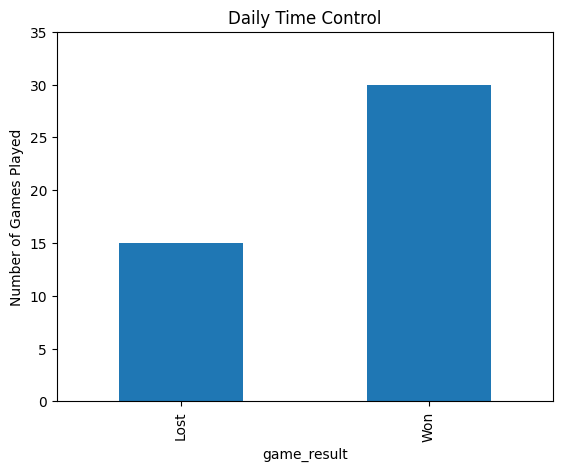

In [28]:
plot_game_result(daily_games, "Daily")

**Figure 1**

game_result
Draw     25
Lost    217
Won     235
dtype: int64


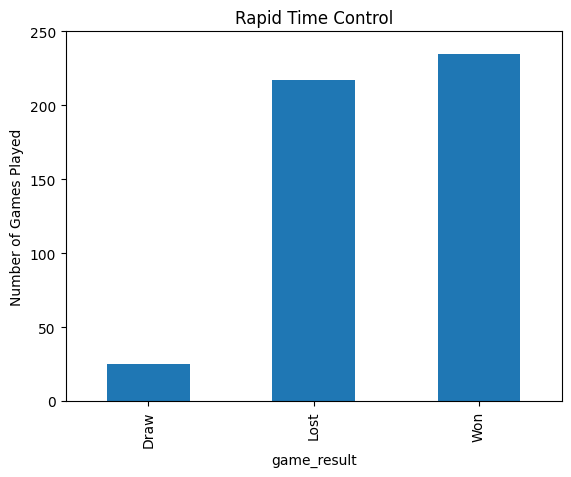

In [29]:
plot_game_result(rapid_games, "Rapid")

**Figure 2**

game_result
Draw     34
Lost    285
Won     292
dtype: int64


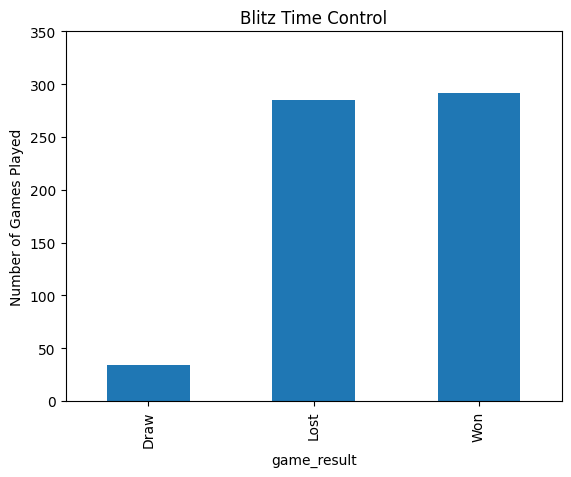

In [30]:
plot_game_result(blitz_games, "Blitz")

**Figure 3**

game_result
Draw     2
Lost    64
Won     55
dtype: int64


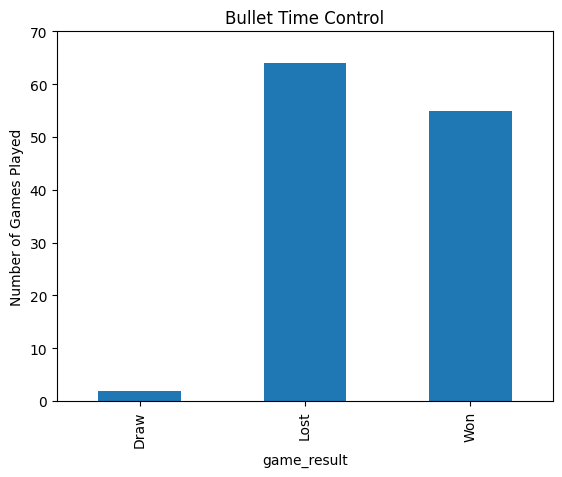

In [31]:
plot_game_result(bullet_games, "Bullet")

**Figure 4**

In [32]:
def plot_rating_over_time(df, time_control):
    """Plots rating over time sampled at a daily frequency.

    Args:
        df (pandas.DataFrame): the chess game data for a particular time control
        time_control (str): time control used in the title for the plot
    """
    (df.resample(rule = "D", on = "start_date")
     .mean(numeric_only = True)["my_rating"]
     .interpolate(method = "time")
     .plot(title = f"{time_control} Game Rating Over Time (Jan 2023 - Present)", grid = True))
    plt.ylabel("Elo Rating")
    plt.show()

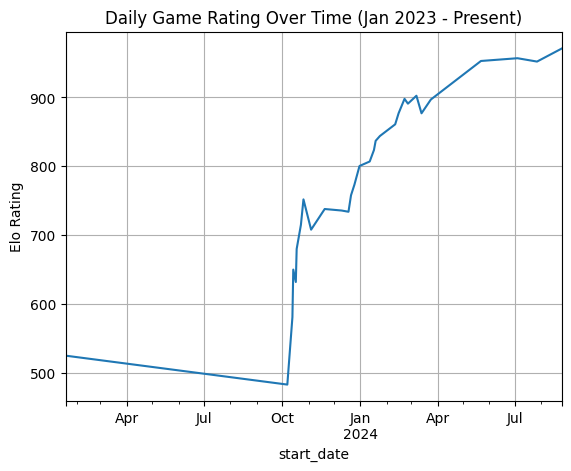

In [33]:
plot_rating_over_time(daily_games, "Daily")

**Figure 5**

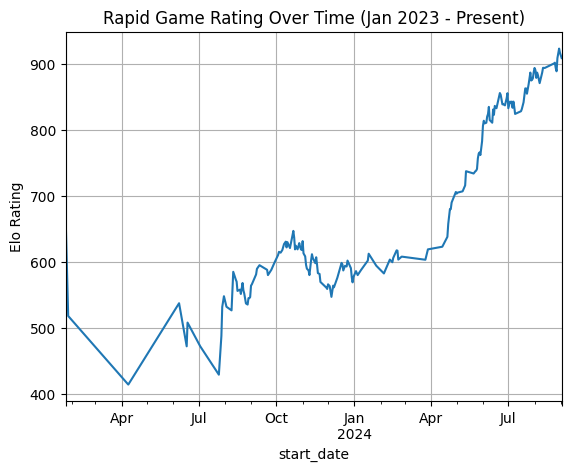

In [34]:
plot_rating_over_time(rapid_games, "Rapid")

**Figure 6**

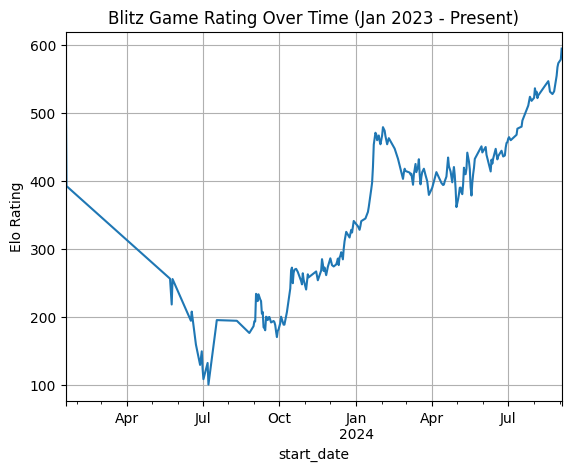

In [35]:
plot_rating_over_time(blitz_games, "Blitz")

**Figure 7**

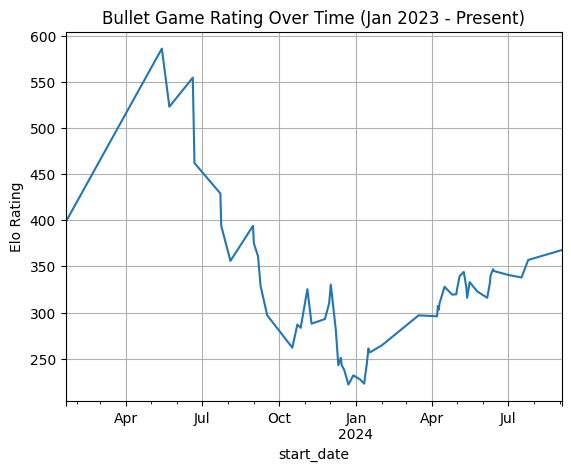

In [36]:
plot_rating_over_time(bullet_games, "Bullet")

**Figure 8**

In [37]:
# Number of unique openings
chess_games["openings"].nunique()

475

In [38]:
# Maximum number of openings played for all time controls
max_num_openings_played = chess_games.groupby("openings").size().max()
max_num_openings_played

30

In [39]:
def plot_openings_by_time_control(df, time_control):
    """Plots the top 10 descending openings played for a given time control.

    Args:
        df (pandas.DataFrame): time control dataframe (i.e. blitz, rapid, daily, or bullet)
        time_control (str): time control used in the title for the plot
    """
    openings = df.groupby("openings").size().sort_values(ascending = False)
    openings[:10].plot(kind = "barh", title = f"Top 10 Openings Played For {time_control} Time Control", xlabel = "Number of Games Played")
    plt.xticks([i for i in range(openings.max() + 1)])
    plt.show()

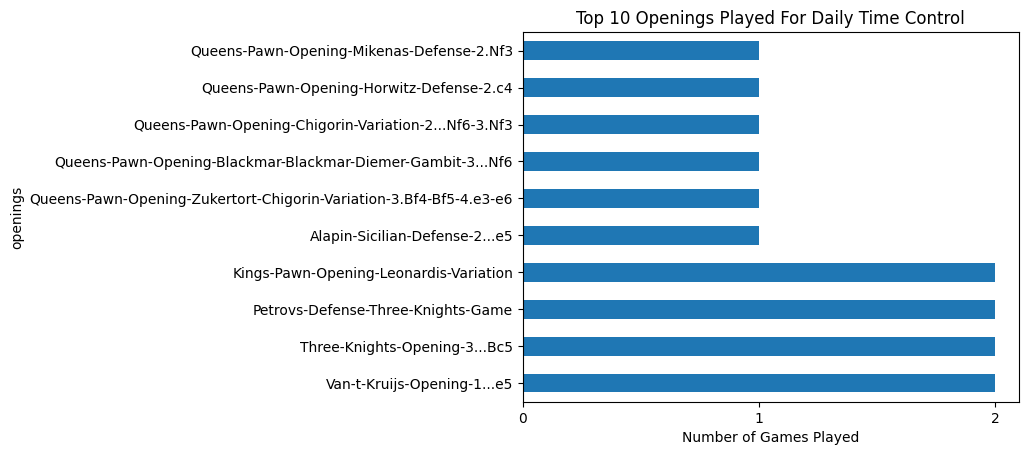

In [40]:
# Top 10 openings played for daily time control
plot_openings_by_time_control(daily_games, "Daily")

**Figure 9**

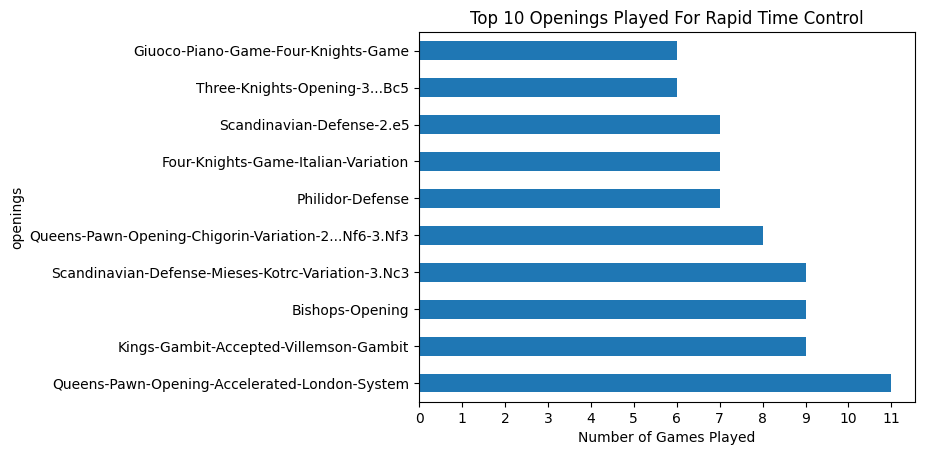

In [41]:
# Top 10 openings played for rapid time control
plot_openings_by_time_control(rapid_games, "Rapid")

**Figure 10**

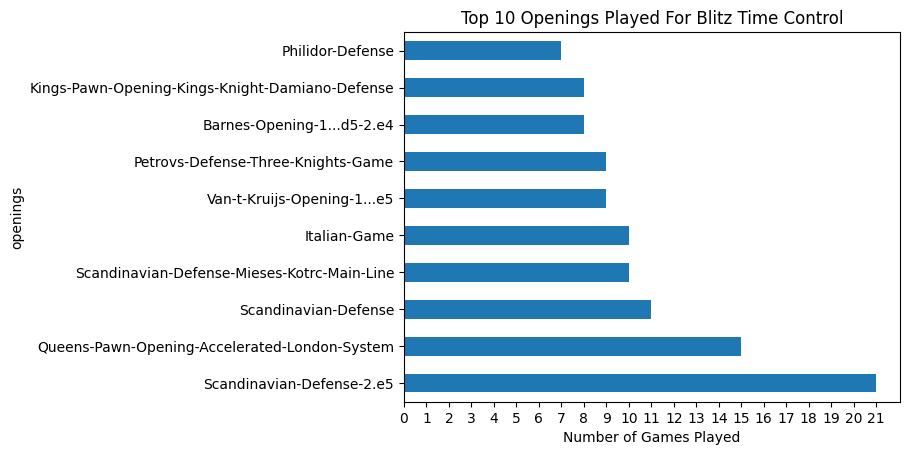

In [42]:
# Top 10 openings played for blitz time control
plot_openings_by_time_control(blitz_games, "Blitz")

**Figure 11**

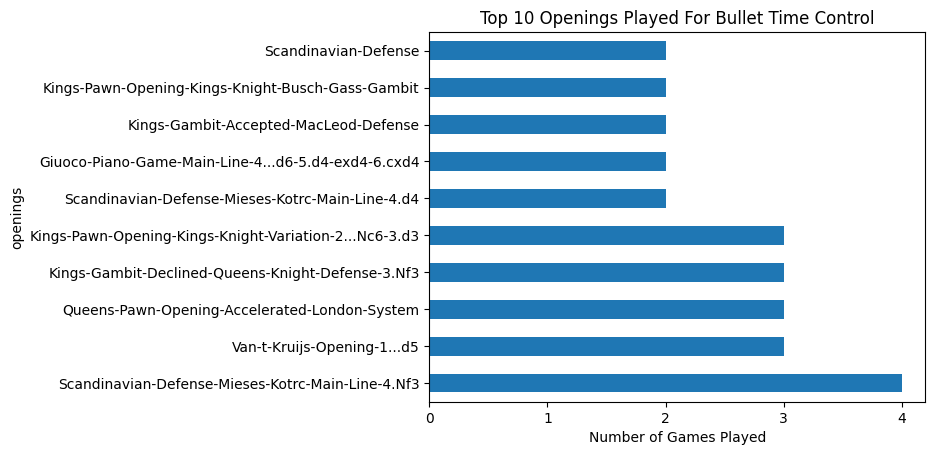

In [43]:
# Top 10 openings played for bullet time control
plot_openings_by_time_control(bullet_games, "Bullet")

**Figure 12**

In [44]:
def plot_openings_matrix(df, time_control):
    """Plots the top 10 descending openings played by game outcome.

    Args:
        df (pandas.DataFrame): time control dataframe
        time_control (str): time control used in the title for the plot
    """
    openings_results = df.groupby(["openings", "game_result"]).size().unstack(fill_value = 0).sort_values(by = "Won", ascending = False)
    ax = sns.heatmap(openings_results[:10], annot=True, cmap='jet')
    cbar = ax.collections[0].colorbar
    cbar.set_ticks([int(tick) for tick in cbar.get_ticks()])
    ax.set_title(f"Top 10 Openings Played By Result For {time_control} Time Control")
    plt.show()

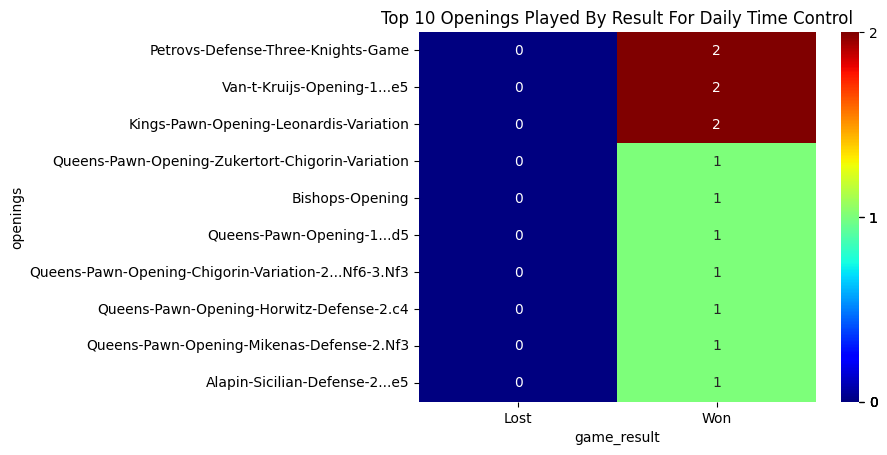

In [45]:
plot_openings_matrix(daily_games, "Daily")

**Figure 13**

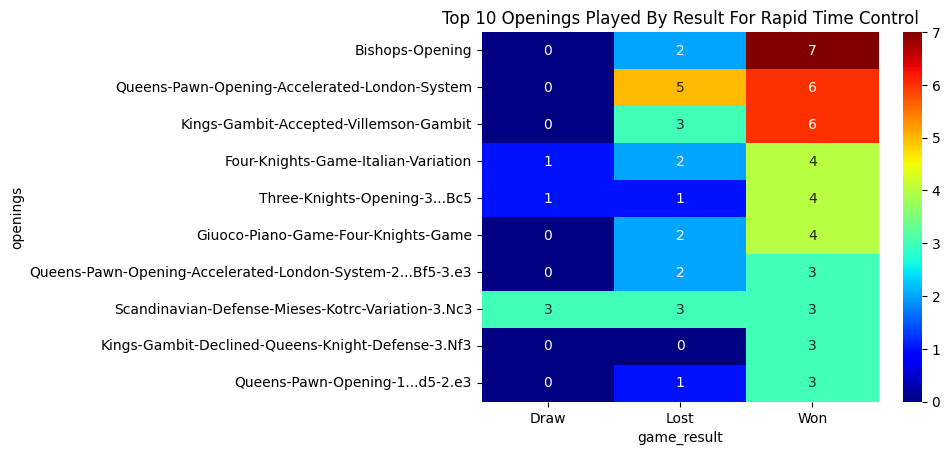

In [46]:
plot_openings_matrix(rapid_games, "Rapid")

**Figure 14**

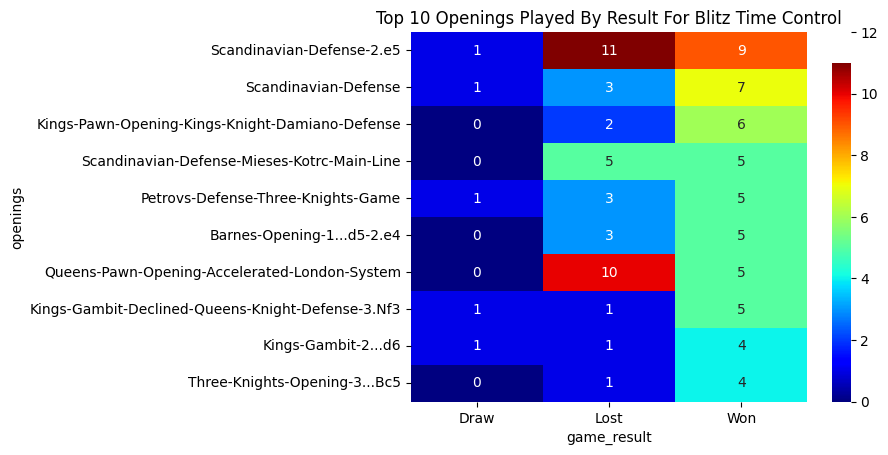

In [47]:
plot_openings_matrix(blitz_games, "Blitz")

**Figure 15**

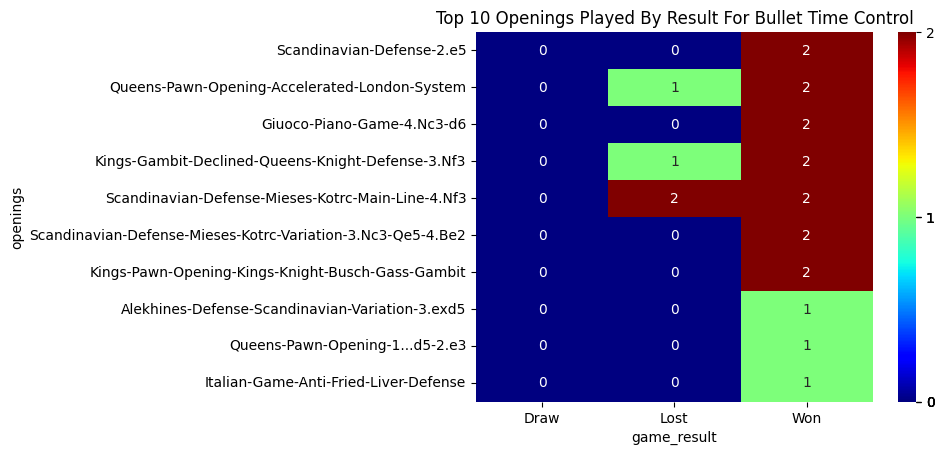

In [48]:
plot_openings_matrix(bullet_games, "Bullet")

**Figure 16**